# Wordnet (słowosieć)

The task concentrates on the usage of a WordNet for finding semantic relations between words and expressions.

## Tasks

1. Read the [Wordnet API](http://api.slowosiec.clarin-pl.eu/docs/index.html)
>zrobione
2. Get acquainted with [semantic relations](http://nlp.pwr.wroc.pl/narzedzia-i-zasoby/narzedzia/disaster/25-wiedza/81-relacje-w-slowosieci) in WordNet.
>zrobione
3. Find all meanings of the _szkoda_ **noun** and display all their synonyms.

In [1]:
import requests

lemma = 'szkoda'
partOfSpeech = 'noun'
def get_senses_ids(lemma, partOfSpeech):
    headers = {'Content-Type': 'application/json',}

    params = (('lemma', lemma),
              ('partOfSpeech', partOfSpeech))

    response = requests.get('http://api.slowosiec.clarin-pl.eu:80/plwordnet-api/senses/search', headers=headers, params=params)
    senses = response.json()['content']
    senses_ids = []
    for sens in senses:
        senses_ids.append(sens['id'])
    return  senses_ids

senses_ids = get_senses_ids(lemma, partOfSpeech)
print(senses_ids)

[8769, 8771]


In [2]:
def get_id_of_owning_synset(word_id):
    response = requests.get('http://api.slowosiec.clarin-pl.eu/plwordnet-api/senses/'+str(word_id)+'/synset')
    synset_id = response.json()['id']
    # print(synset_id)
    return synset_id

synset_id = get_id_of_owning_synset(8769)
print(synset_id)

6533


In [3]:
def get_synset_atribute(synset_id):
    response = requests.get('http://api.slowosiec.clarin-pl.eu/plwordnet-api/synsets/'+str(synset_id)+'/attributes')
    atribute = response.json()[0]['value']
    return atribute

In [4]:
def get_unitString_for_synset_id(synset_id):
    response = requests.get('http://api.slowosiec.clarin-pl.eu/plwordnet-api/synsets/'+str(synset_id)+'/unitString')
    unitString = response.json()['value']
    return unitString

unitString = get_unitString_for_synset_id(3675)
print(unitString)

(strata 1 (zdarz) | utrata 1 (zdarz), szkoda 2 (pos), uszczerbek 1 (zdarz))


In [5]:
attributes = []
for sens_id in senses_ids:
    synset_id = get_id_of_owning_synset(sens_id)
    attribute = get_synset_atribute(synset_id)
    unitString = get_unitString_for_synset_id(synset_id)
    print('Synset id: {}, atribut: {}'.format(synset_id, attribute))
    print('Synonimy: {}'.format(unitString))


Synset id: 6533, atribut: ziemia w gospodarstwie zniszczona przez zwierzęta
Synonimy: (szkoda 1 (msc) | )
Synset id: 3675, atribut: 0
Synonimy: (strata 1 (zdarz) | utrata 1 (zdarz), szkoda 2 (pos), uszczerbek 1 (zdarz))


4. Find closure of **hypernymy** relation for the first meaning of the _wypadek drogowy_ expression.
   Create diagram of the relations as a directed graph.

In [6]:
word = 'wypadek drogowy'

def get_word_id(word):
    params = (('lemma', word),)
    response = requests.get('http://api.slowosiec.clarin-pl.eu:80/plwordnet-api/senses/search', params=params)
    word_id = response.json()[('content')][0]['id']
    # print(word_id)
    return word_id

word_id = get_word_id(word)
print(word_id)

644786


In [7]:
def find_hyperonym_synset_for_synset_id(synset_id):
# the name of the relation
    response = requests.get('http://api.slowosiec.clarin-pl.eu/plwordnet-api/synsets/'+str(synset_id)+'/relations')
    synsets = response.json()
    for synset in synsets:
        # print(synset)
        if synset['relation']['name']=='hiponimia':
            # print(synset['id'])
            hyperonym_synset_id = synset['synsetTo']['id']
            # print(hyperonym_synset_id)
            return hyperonym_synset_id
    return 0

hyperonym_synset_id = find_hyperonym_synset_for_synset_id(synset_id)
print(hyperonym_synset_id)

102819


In [8]:
def get_lemmas_of_synset(synset_id):
    response = requests.get('http://api.slowosiec.clarin-pl.eu/plwordnet-api/synsets/'+str(synset_id)+'/senses')
    lemma = response.json()[0]['lemma']['word']
    # print(lemma)
    return lemma

lemma = get_lemmas_of_synset(hyperonym_synset_id)
print(lemma)

niepowodzenie


In [9]:
word ='wypadek drogowy'
more = False
words = [word]
while True:
    word_id = get_word_id(word)
    synset_id = get_id_of_owning_synset(word_id)
    hyperonym_synset_id = find_hyperonym_synset_for_synset_id(synset_id)
    new_word = get_lemmas_of_synset(hyperonym_synset_id)
    if word == new_word:
        break
    word = new_word
    words.append(word)
print(words)

['wypadek drogowy', 'wypadek komunikacyjny', 'wypadek', 'zdarzenie oceniane negatywnie', 'wydarzenie']


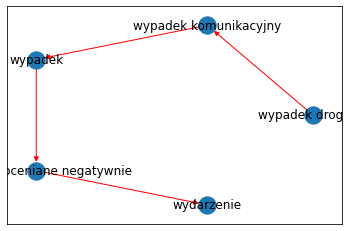

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
for i in range(len(words)):
    G.add_node(words[i])
    if i > 0:
        G.add_edge(words[i-1], words[i])

pos = nx.circular_layout(G)

nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='r', arrows = True)

plt.show()

5. Find direct **hyponyms** of _wypadek<sub>1</sub>_ noun.

In [11]:
word = 'wypadek'
partOfSpeech = 'noun'
sens_id =get_senses_ids(word, partOfSpeech)[0]
print('Sens id of {}1: {}'.format(word, sens_id))

synset_id = get_id_of_owning_synset(sens_id)


print('Synset id: {}'.format(synset_id))

def find_hyponyms_synsets_for_synset_id(synset_id):
# the name of the relation
    response = requests.get('http://api.slowosiec.clarin-pl.eu/plwordnet-api/synsets/'+str(synset_id)+'/relations')
    synsets = response.json()
    hyponyms_synsets_id = []
    for synset in synsets:
        # print(synset)
        if synset['relation']['name']=='hiperonimia':
            # print(synset['id'])
            hyponym_synset_id = synset['synsetTo']['id']
            # print(hyponym_synset_id)
            hyponyms_synsets_id.append(hyponym_synset_id)
            # return hyperonym_synset_id
        if synset['relation']['name']=='hiponimia':
            # print(synset['id'])
            hyponym_synset_id = synset['synsetFrom']['id']
            # print(hyponym_synset_id)
            hyponyms_synsets_id.append(hyponym_synset_id)
            # return hyperonym_synset_id
    return hyponyms_synsets_id

hyponyms_synsets_id = find_hyponyms_synsets_for_synset_id(synset_id)
print(hyponyms_synsets_id)

print('hiponimy:')
lemmas = {}
for synset_id in hyponyms_synsets_id:
    lemma = get_lemmas_of_synset(synset_id)
    if lemma not in lemmas:
        lemmas[(lemma)] = 1
print(lemmas)
i=1
for word in lemmas:
    print(i, word)
    i+=1

# todo : liczba hiponimów nie zgadza się z liczbą z
# http://plwordnet.pwr.wroc.pl/wordnet/44444f10-28e9-11eb-b940-23b9cbb5a1e1

Sens id of wypadek1: 21890
Synset id: 3982
[3982, 34688, 34689, 258635, 258639, 389170, 410901, 411618, 3982, 34688, 34689, 258635, 258639, 389170, 410901, 411618]
hiponimy:
{'wypadek': 1, 'zawał': 1, 'tąpnięcie': 1, 'katastrofa': 1, 'wykolejenie': 1, 'zakrztuszenie': 1, 'wypadek komunikacyjny': 1, 'katastrofa budowlana': 1}
1 wypadek
2 zawał
3 tąpnięcie
4 katastrofa
5 wykolejenie
6 zakrztuszenie
7 wypadek komunikacyjny
8 katastrofa budowlana


6. Find second-order **hyponyms** of the same noun.



7. Display as a directed graph (with labels for the edges) semantic relations between the following groups of lexemes:

   i. szkoda<sub>2</sub>, strata<sub>1</sub>, uszczerbek<sub>1</sub>, szkoda majątkowa<sub>1</sub>,
      uszczerbek na zdrowiu<sub>1</sub>, krzywda<sub>1</sub>, niesprawiedliwość<sub>1</sub>, nieszczęście<sub>2</sub>.

   ii. wypadek<sub>1</sub>, wypadek komunikacyjny<sub>1</sub>, kolizja<sub>2</sub>, zderzenie<sub>2</sub>,
      kolizja drogowa<sub>1</sub>, bezkolizyjny<sub>2</sub>, katastrofa budowlana<sub>1</sub>, wypadek
      drogowy<sub>1</sub>.

8. Find the value of [Leacock-Chodorow semantic similarity measure](ftp://www-vhost.cs.toronto.edu/public_html/public_html/pub/gh/Budanitsky+Hirst-2001.pdf)
   between following pairs of lexemes:
   i. szkoda<sub>2</sub> - wypadek<sub>1</sub>,
   ii. kolizja<sub>2</sub> - szkoda majątkowa<sub>1</sub>,
   iii. nieszczęście<sub>2</sub> - katastrofa budowlana<sub>1</sub>.

9. Questions/problems:

   i. What is the necessary step to use the knowlege from dictionaries such as WordNet?
   > Konieczna jest znajomość powiązań między poszczególnymi informacjami dostępnymi przez API

   ii. Assess the value of WordNet as a resource for representing the sense of sentences (not words in isolation).
   > Do oceny znaczenia zdań przy wykorzystaniu WordNet potrzebne jest dodatkowe narzędzie niezbędne do dezambiguacji poszczególnych słów.

   iii. Discuss the problmes comming from using structured knowledge resources such as WordNet.
   > Niewłaściwe poruszanie się po strukturze może dawać błędne wyniki.


## Hints

1. WordNet is a semantic dictionary that has the following features:
   1. it identifies **the meanings** of the words, i.e. _zamek_ in the sense of a _castle_ and _zamek_ in the sense of a  _tool_ have two distinct representations,
   1. it describes these meaning using **semantic relations**, e.g. _zamek<sub>1</sub>_ is a **hyponym** of
      _budynek<sub>1</sub>_ and _zamek<sub>2</sub>_ is a **hypernym** of _zatrzasku<sub>2</sub>_.
1. The meaning of a lexeme is identified by an index, e.g. _zamek<sub>1</sub>_ identifies the first meaning and
   _zamek<sub>2</sub>_ the second, etc.
1. WordNet defines **lexemes** and **synsets**. The lexemes roughly correspond to words, i.e. we say that a lexeme with
   an index _has_ a particular meaning, e.g.  _zamek<sub>2</sub>_  refers to a tool for closing things.
   But that meaning is obtained thanks to its participation to a particular _synset_. A synset is a set of lexemes that
   share meaning. E.g. _szkoda<sub>2</sub>_, _uszczerbek<sub>1</sub>_, _strata<sub>1</sub>_ and _utrata<sub>1</sub>_
   belong to one synset. As a consequence the definition and most of the relations are attached to a synset, rather than
   a lexeme. Lexemes belonging to a particular synset are called synonyms.
1. The [webapi of WordNet](http://api.slowosiec.clarin-pl.eu/docs/index.html) might be used in the following way (I use
   [jq](https://www.npmjs.com/package/node-jq) library to post-prcess the JSON response):
   * `curl -X GET http://api.slowosiec.clarin-pl.eu/plwordnet-api/senses/search\?lemma\=gol | jq '.content[] | .id'`
     - get all ids of senses of a given lexeme (**gol** in this example)
   * `curl -X GET http://api.slowosiec.clarin-pl.eu/plwordnet-api/senses/1944/synset | jq .id`
     - get id of the owning synset (for the first sense of **gol**)
   * `curl -X GET http://api.slowosiec.clarin-pl.eu/plwordnet-api/synsets/65421/relations | jq '.[] | .synsetTo.id'`
     - get ids of all related synsets.
     The query ignores the type of relation and half of the results just returns the ID of the source synset.
   * `curl -X GET http://api.slowosiec.clarin-pl.eu/plwordnet-api/synsets/65421/relations | jq '.[] | .relation.name'`
     - return the name of the relation corresponding to the ID above.
   * `curl -X GET http://api.slowosiec.clarin-pl.eu/plwordnet-api/synsets/285651/senses | jq '.[] | .lemma.word'`
     - get lemmas of a given synset.
1. The [NLTK](https://www.nltk.org/) library has an [implementation](http://www.nltk.org/howto/wordnet.html) of Leacock-Chodorow measure,
   but it does not integrate with the Polish WordNet.
1. The [pywnxml](https://github.com/ppke-nlpg/pywnxml) library allows for reading the Polish WordNet, but it lacks that
   measure.
1. The contents of the Polish WordNet may also be accessed by a [web API](http://api.slowosiec.clarin-pl.eu/docs/index.html)
1. The [statistics](http://plwordnet.pwr.wroc.pl/wordnet/stats) of the Polish WordNet with a shorter list of relations..